![](https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg)

# 0. Intro
### Основная идея: Делаем решение на базе U-Net

In [1]:
import os
import sys
import glob
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.20.3
Skimage      : 0.19.1
Keras        : 2.6.0
Tensorflow   : 2.6.2


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP

In [4]:
# SETUP
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

BATCH_SIZE      = 32
NUM_EPOCHS      = 50
# STEPS_PER_EPOCH = 600
LR              = 0.001
validation_split= 0.1

# 1. Load Data
распаковываем данные

In [5]:
# распаковываем данные
import zipfile
for name_data in ['test', 'train']:
    tmp_zip = zipfile.ZipFile('../input/'+name_data+'.zip')
    tmp_zip.extractall(name_data)
    tmp_zip.close()

Для начала глянем csv

In [6]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission.sample(5)

,ImageId,EncodedPixels
53,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,1 1
60,eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9...,1 1
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,1 1
45,a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a26...,1 1
5,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,1 1


In [7]:
len(sample_submission)

65

Не кажеться странным, что нам предлагают на тест только 65 уникальных картинок? )  
посмотрим что в трейне...

In [8]:
train_labels = pd.read_csv('../input/train_labels.csv')
train_labels.sample(10)

,ImageId,EncodedPixels
16141,8b77284d6f37ab3fc826139ebadaec3b9d81c552fe525c...,55530 7 55784 12 56039 14 56294 16 56549 18 56...
27194,ea94ba4b01d1bd5f7768d10e0ac547743791033df545c7...,12295 8 12550 11 12805 14 13060 17 13316 18 13...
24216,cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9...,37435 5 37690 7 37945 8 38201 8 38457 8 38713 ...
25304,da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e751...,18647 6 19166 8 19686 9 20206 9 20726 8 21247 ...
21273,b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d4...,331026 5 331543 9 332062 12 332580 15 333099 1...
9796,538b7673d507014d83af238876e03617396b70fe27f525...,127462 4 128064 8 128666 12 129268 16 129870 2...
3410,1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526...,431986 4 433009 5 434033 5 435057 6 436081 6 4...
16126,8aa1a883f61f0bb5af3d3d60acaaf33af45ef4fbffaac1...,59092 3 59345 8 59600 11 59856 11 60112 11 603...
9577,4e23ecf65040f86420e0201134e538951acdeda84fbb27...,55041 2 55297 4 55553 5 55809 6 56065 6 56321 ...
27756,ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5...,23588 3 23843 5 24099 5 24355 5 24612 3


In [9]:
len(train_labels)

29461

в описании датасета написано что "Каждая маска содержит одно ядро."  
А из всех 29к примеров, сколько у нас уникальных изображений для тренировки на самом деле?

In [10]:
len(train_labels) - train_labels.ImageId.duplicated().sum()

670

Сверяем по папкам

In [11]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))
test_ids = next(os.walk(TEST_PATH))

mask_count = 0
for train_id in train_ids[1]:
    masks = next(os.walk(TRAIN_PATH + train_id + '/masks/'))[2]
    mask_count += len(masks)

print('There are {} images.'.format(len(train_ids[1])))
print('There are {} masks.'.format(mask_count))
print('Approximately {} masks per image.'.format(mask_count // len(train_ids[1])))

There are 670 images.
There are 29461 masks.
Approximately 43 masks per image.


Вот все и встало на свои места, Итого 65 изображений на тесте и 670 на трейне.  
Давай подгрузим и посмотрим эти картинки

In [12]:
# для подгрузки данных будем использовать удобную либу skimage
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], 
                                                output_shape=output_shape, 
                                                mode='constant', 
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

In [13]:
%%time
# Get training data
X_train = get_X_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(X_train.shape, X_train.dtype)

(670, 256, 256, 3) uint8
CPU times: user 19.4 s, sys: 871 ms, total: 20.3 s
Wall time: 20.3 s


In [14]:
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data

In [15]:
%%time
# Get training data labels
Y_train = get_Y_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(Y_train.shape, Y_train.dtype)

(670, 256, 256, 1) bool
CPU times: user 41 s, sys: 3.61 s, total: 44.6 s
Wall time: 44.9 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


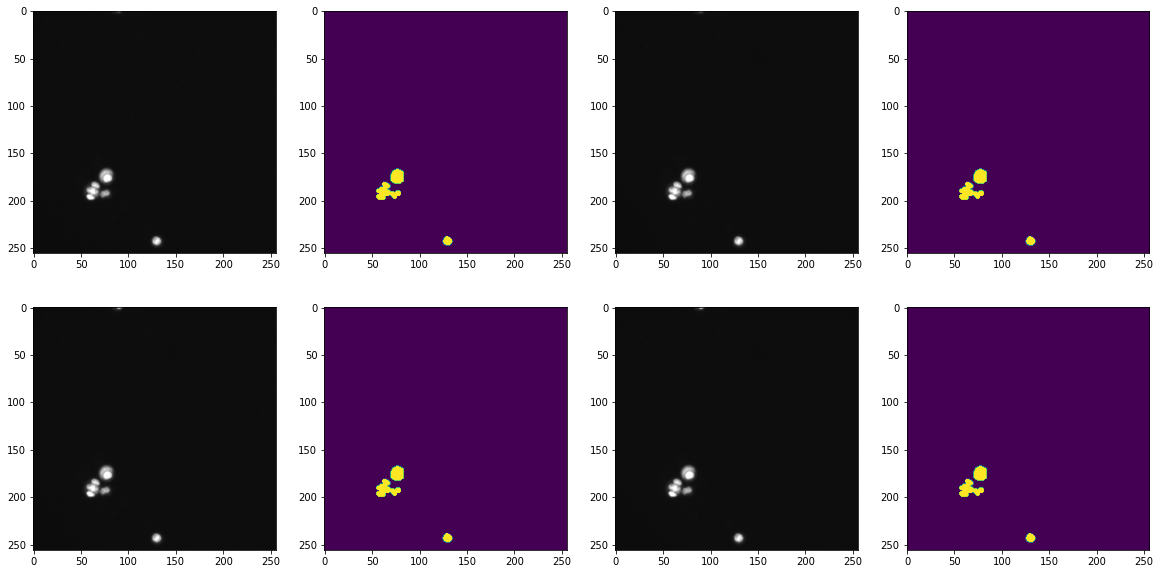

In [16]:
# Check training data
f, axarr = plt.subplots(2,4)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,1].imshow(np.squeeze(Y_train[ix]))

axarr[0,2].imshow(X_train[ix])
axarr[0,3].imshow(np.squeeze(Y_train[ix]))

axarr[1,0].imshow(X_train[ix])
axarr[1,1].imshow(np.squeeze(Y_train[ix]))

axarr[1,2].imshow(X_train[ix])
axarr[1,3].imshow(np.squeeze(Y_train[ix]))

plt.show()

# 2. Build model

> Построим U-Net model, по мотивам [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) и близко к этому [репозиторию](https://github.com/jocicmarko/ultrasound-nerve-segmentation) из Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [17]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
#c5 = BatchNormalization() (c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
optimizer = Adam(lr=LR,)
model.compile(optimizer=optimizer, loss='binary_crossentropy',)
model.summary()

2022-03-21 07:41:32.720256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 07:41:32.806809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 07:41:32.807496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 07:41:32.808725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
# Fit model
history = model.fit(X_train, Y_train, 
                    validation_split=validation_split, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    verbose=2,)

2022-03-21 07:41:35.271153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-21 07:41:37.377588: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


19/19 - 13s - loss: 0.4825 - val_loss: 0.2672
Epoch 2/50
19/19 - 3s - loss: 0.3042 - val_loss: 0.1885
Epoch 3/50
19/19 - 3s - loss: 0.1813 - val_loss: 0.1278
Epoch 4/50
19/19 - 3s - loss: 0.1351 - val_loss: 0.1299
Epoch 5/50
19/19 - 3s - loss: 0.1342 - val_loss: 0.1044
Epoch 6/50
19/19 - 3s - loss: 0.1195 - val_loss: 0.0968
Epoch 7/50
19/19 - 3s - loss: 0.1146 - val_loss: 0.1021
Epoch 8/50
19/19 - 3s - loss: 0.1167 - val_loss: 0.0949
Epoch 9/50
19/19 - 3s - loss: 0.1127 - val_loss: 0.0998
Epoch 10/50
19/19 - 3s - loss: 0.1086 - val_loss: 0.0865
Epoch 11/50
19/19 - 3s - loss: 0.0993 - val_loss: 0.0815
Epoch 12/50
19/19 - 3s - loss: 0.0996 - val_loss: 0.0847
Epoch 13/50
19/19 - 3s - loss: 0.0925 - val_loss: 0.0816
Epoch 14/50
19/19 - 3s - loss: 0.0887 - val_loss: 0.0793
Epoch 15/50
19/19 - 3s - loss: 0.0853 - val_loss: 0.0768
Epoch 16/50
19/19 - 3s - loss: 0.0834 - val_loss: 0.0790
Epoch 17/50
19/19 - 3s - loss: 0.0872 - val_loss: 0.0783
Epoch 18/50
19/19 - 3s - loss: 0.0827 - val_loss: 

In [19]:
model.save('keras_unet.h5')

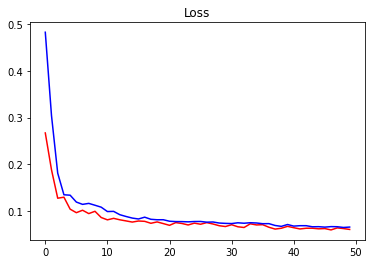

In [20]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()
    
plot_loss_history(history)

# 3. Make predictions

In [21]:
# Use model to predict train labels
model = load_model('keras_unet.h5',)
Y_predict = model.predict(X_train, verbose=1)
Y_predict.shape

21/21 [==============================] - 1s 61ms/step


(670, 256, 256, 1)

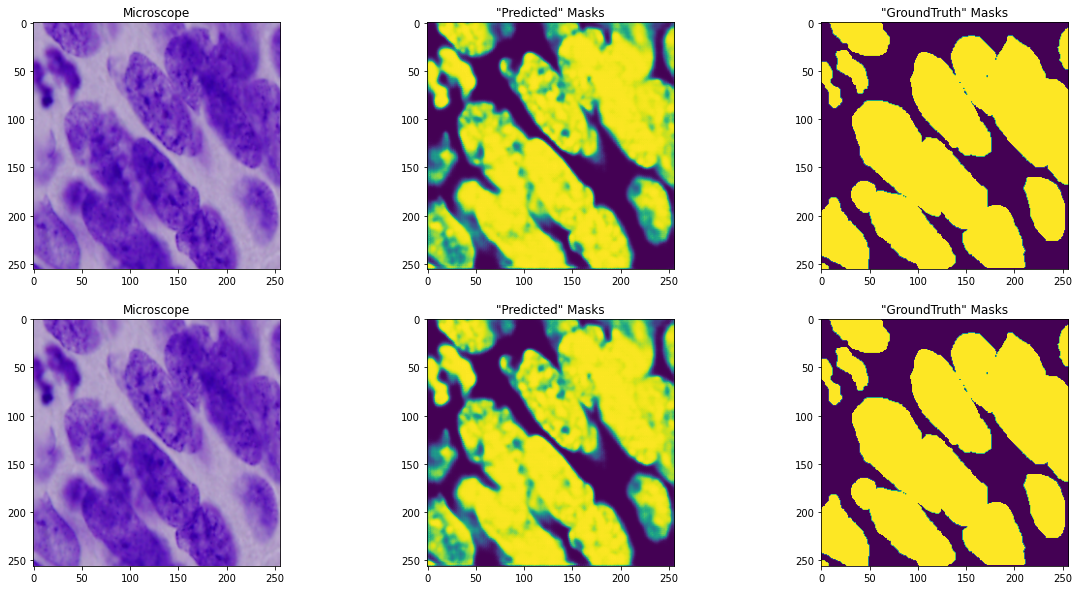

In [22]:
# Check predict data
f, axarr = plt.subplots(2,3)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,0].set_title('Microscope')
axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
axarr[0,1].set_title('"Predicted" Masks')
axarr[0,2].imshow(np.squeeze(Y_train[ix]))
axarr[0,2].set_title('"GroundTruth" Masks')

axarr[1,0].imshow(X_train[ix])
axarr[1,0].set_title('Microscope')
axarr[1,1].imshow(np.squeeze(Y_predict[ix]))
axarr[1,1].set_title('"Predicted" Masks')
axarr[1,2].imshow(np.squeeze(Y_train[ix]))
axarr[1,2].set_title('"GroundTruth" Masks')

plt.show()

Смотриться хорошо

In [23]:
# Get test data
X_test = get_X_data(TEST_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))

# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)
Y_hat.shape

3/3 [==============================] - 0s 115ms/step


(65, 256, 256, 1)

(256, 256, 3)


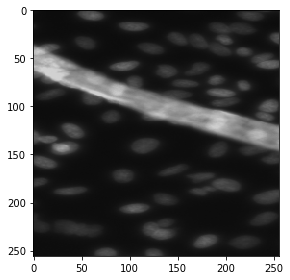

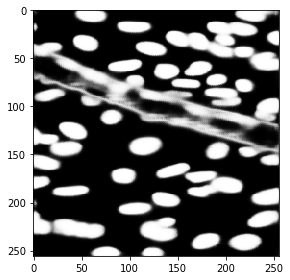

In [24]:
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show()
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show()

# 4. Encode and Submit

In [25]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

мы ресайзили картинку до 256х256, но чтоб верно предсказать, нам нужно сделать маску под размер изначальной картинки

In [26]:
# Upsample Y_hat back to the original X_test size (height and width)
Y_hat_upsampled = []
for i, test_id in enumerate(os.listdir(TEST_PATH)):  #loop through test_ids in the test_path
    img = skimage.io.imread('{0}/{1}/images/{1}.png'.format(TEST_PATH, test_id))  #read original test image directly from path
    img_upscaled = skimage.transform.resize(Y_hat[i], (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)  #upscale Y_hat image according to original test image
    Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
len(Y_hat_upsampled)

65

Осталось закодировать нашу маску

In [27]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for n, id_ in enumerate(os.listdir(TEST_PATH)):
    rle = list(prob_to_rles(Y_hat_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

2034

In [28]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)

In [29]:
sub.head()

,ImageId,EncodedPixels
0,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,1 63 520 62 1039 61 1558 17 1576 42 2077 17 20...
1,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,68511 5 69029 7 69547 8 70066 9 70585 10 71104...
2,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,31153 10 31670 15 32189 17 32707 19 33225 22 3...
3,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,55038 5 55555 9 56073 11 56591 14 57108 18 576...
4,1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e...,73744 10 74257 19 74772 24 75289 28 75807 30 7...


In [30]:
len(sub)

2034

In [31]:
# Clean Folder
import shutil
shutil.rmtree('train')
shutil.rmtree('test')

Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Добавить свою метрику (для сегментации loss не лучшая метрика) и callbacks по ней
* Поставить и подобрать Threshold для predictions
* Добавить аугментацию
* Поиграться с архитектурой
* Подобрать другие переменные (размер картинки, батч и тп)
* Добавить политику обучения
* Добавить TTA
* Найти и обучиться на других внешних данных
* Построить ансамбль из разных архитектур

Удачи в соревновании!